##Is it a bird?


So here we are gonna get some random images from google (duckduckgo to be precise 🤭) and try classifying them as bird images or not


In [ ]:
#@title Step 0: Install required libraries
!pip install -Uqq fastai duckduckgo_search keras-preprocessing

In [ ]:
#@title Step 1: Download images of birds and non-birds

from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [ ]:
# `search_images` function depends on duckduckgo.com, which doesn't always return correct responses.
# If you get a JSON error, just try running it again

urls = search_images('plane photos', max_images=1)
print(urls[0])

Searching for 'plane photos'
https://get.pxhere.com/photo/airplane-plane-aircraft-vehicle-airline-aviation-flight-aeroplane-airliner-boeing-jet-aircraft-air-travel-boeing-737-passenger-jet-commercial-aircraft-atmosphere-of-earth-narrow-body-aircraft-boeing-737-next-generation-boeing-c-40-clipper-air-new-zealand-commercial-airliner-commercial-jet-1353073.jpg


...and then download a URL and take a look at it:

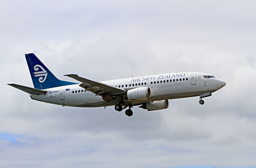

In [ ]:
from fastdownload import download_url
dest = 'plane.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "forest photos":

Searching for 'forest photos'


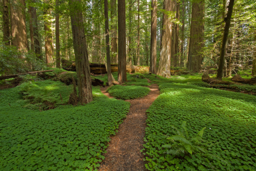

In [ ]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "bird" and "forest" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [ ]:
searches = 'boat','plane'
path = Path('boat_plane')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(5)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(5)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'boat photo'
Searching for 'boat sun photo'
Searching for 'boat shade photo'
Searching for 'plane photo'
Searching for 'plane sun photo'
Searching for 'plane shade photo'


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

4

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

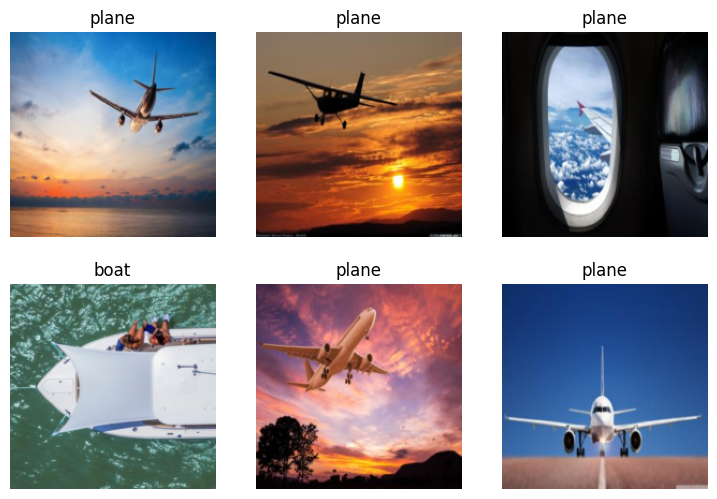

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

###More info

Here what each of the `DataBlock` parameters means:
1. `blocks=(ImageBlock, CategoryBlock)`

  >The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

2. `get_items=get_image_files,`

  >To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

3. `splitter=RandomSplitter(valid_pct=0.2, seed=42)`

  >Split the data into training and validation sets randomly, using 20% of the data for the validation set.

4. `get_y=parent_label`

  >The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

5. `item_tfms=[Resize(192, method='squish')]`

  >Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

  `fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.068886,1.184373,0.483871,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.439286,0.541435,0.193548,00:01
1,0.267416,0.413355,0.161290,00:00
2,0.204371,0.377149,0.161290,00:00




>"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) .

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [ ]:
is_bird,_,probs = learn.predict(PILImage.create('plane.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a plane: {probs[0]:.4f}")

This is a: plane.
Probability it's a plane: 0.0032


In [ ]:
#@title Try uploading random images
from google.colab import files
from keras_preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(256, 256))
  is_bird,_,probs = learn.predict(PILImage.create(img))
  print(f"This is a: {is_bird}.")
  print(f"Probability it's a bird: {probs[0]:.4f}")



KeyboardInterrupt: ignored



---



Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard, it's a joke" to "trivially easy and free"!


It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

Now it's your turn. Try creating your own image classifier using your own image searches!

